In [23]:
from writers import DictSaver
from analyzers import IntensitySegmenter
from datasets import TomographyArray
from utils.data_factory import DataFactory
from image_processing_pipelines import ThresholdClusterPipeline
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import sympy as sp
import ipywidgets as widgets
from IPython.display import HTML
import numpy as np
import matplotlib
from scipy.stats import entropy
import cv2


In [24]:
# Sets up a tomography to pull slices from
print("Compiling Dataset...")
factor = 5
save_path = "presentation_videos/SAM/"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/TomoDB1_d1/FlagellarMotor_P1/Hylemonella gracilis/yc2013-01-03-21/Bdel_Hyle_0020009_full.rec"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/TomoDB1_d1/FlagellarMotor_P1/Brucella_abortus/aba2014-03-17-41/BrucellaWT0009_part121_8.rec"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/TomoDB1_d1/FlagellarMotor_P1/Agrobacterium_tumefaciens_MS/Agrobacterium_MS_try2/et2014-03-05-15/4_pJW58_20008_full.rec"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/TomoDB1_d1/FlagellarMotor_P1/CaulobacterCrescentus_UnpluggedPL/lza2018-10-20-13/targ65_full.rec"
tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d3/nobackup/archive/TomoDB1_d3/Bdellovibrio_Krios/ConventionalTilt/good/FromGeorges_FastTilt/17/BD_1deg_2um_Aug25_15.30.48_af_combined_SIRT_1k.ctf.rec"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d4/nobackup/archive/copick_root/ExperimentRuns/sma2022-03-21-50/sm3_21VibrioWT_049_rec.mrc"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d2/nobackup/archive/TomoDB1_d2/FlagellarMotor_P2/Proteus_mirabilis/"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d4/nobackup/archive/copick_root/ExperimentRuns/"
data = TomographyArray([tomo_path])

Compiling Dataset...
Initialized with 1 files.


In [25]:
# Sets up an analysis pipeline
print("Setting up Analysis Pipeline...")
analyzer = IntensitySegmenter(factor=factor)

# Sets up a writer
print("Setting up Writer...")
writer = DictSaver("intensity_segmenter.json")

print("Configuring Processor...")
batch_size = 1
data_factory = DataFactory(
    analyzer,
    writer,
    batch_size
)

Setting up Analysis Pipeline...
Setting up Writer...
No existing file found. A new file will be created at intensity_segmenter.json.
Configuring Processor...


In [26]:
print("Processing Data...")
results = data_factory.process(data, "Processing Slice")

Processing Data...


Processing Slice: 100%|██████████| 1/1 [00:18<00:00, 18.95s/it]

Done with /home/matiasgp/groups/grp_tomo_db1_d3/nobackup/archive/TomoDB1_d3/Bdellovibrio_Krios/ConventionalTilt/good/FromGeorges_FastTilt/17/BD_1deg_2um_Aug25_15.30.48_af_combined_SIRT_1k.ctf.rec


This is a function to load the data from the .json file

In [27]:
# import json

# def load_dict_from_json(file_path):
#     """
#     Load a dictionary from a .json file.
    
#     Parameters:
#     - file_path: str, path to the .json file.

#     Returns:
#     - dict: The dictionary loaded from the file.
#     """
#     try:
#         with open(file_path, 'r') as file:
#             data = json.load(file)
#             return data
#     except FileNotFoundError:
#         print(f"Error: The file '{file_path}' was not found.")
#         return None
#     except json.JSONDecodeError:
#         print(f"Error: The file '{file_path}' is not a valid JSON file.")
#         return None
#     except Exception as e:
#         print(f"An error occurred: {e}")
#         return None
    
# results = load_dict_from_json("intensity_segmenter_stefano.json")



In [28]:
def min_max_normalize(array):
    # Convert to float32 to prevent overflow issues
    array = array.astype(np.float32)
    
    min_val = np.min(array)
    max_val = np.max(array)
    
    if min_val == max_val:
        # Avoid division by zero if the array contains a single unique value
        return np.zeros(array.shape, dtype=np.float32)
    
    normalized_array = (array - min_val) / (max_val - min_val)
    return normalized_array


def histogram_equalization_3d(image):
    """
    Apply histogram equalization to a 3D array.
    
    Args:
    - image (np.ndarray): 3D array representing the image or volume.
    
    Returns:
    - image_equalized (np.ndarray): Histogram-equalized 3D array.
    """
    # Flatten the 3D image array and calculate histogram
    hist, bins = np.histogram(image.flatten(), bins=256, range=[0, 1])

    # Calculate cumulative distribution function (CDF)
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()  # Normalize CDF

    # Use linear interpolation of the CDF to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf_normalized)

    # Reshape the flattened image back to the original 3D shape
    image_equalized = image_equalized.reshape(image.shape)
    
    return image_equalized

Now we want to plot the entropy analysis in a graph, just like the means analyzer.

In [29]:
def plot_in_notebook(array, num_slices=10, save_path=None, custom_name=None, speed_factor=2, show_in_notebook=False):
    """
    Plot a 3D numpy array as animated slices with average of specified number of slices.
    The animations are 30% smaller and use grayscale, and only the shortest axis is plotted.
    
    Parameters:
    - array: 3D numpy array to plot
    - num_slices: Number of slices to average in each frame
    - save_path: Directory path to save the animations as videos. If None, videos are not saved.
    - custom_name: Custom name to be included in the saved video file name and the plot title.
    - speed_factor: A multiplier to control the speed of the animation (higher value means faster animation).
    - show_in_notebook: Boolean flag to control whether the animation is displayed in the notebook or not.
    """
    
    # Determine the shortest axis
    shortest_axis = np.argmin(array.shape)
    
    def update_plot(frame, axis, ax):
        ax.cla()  # Clear the current plot
        
        
        if axis == 0:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[axis], frame + num_slices // 2 + 1)
            slices = array[start_slice:end_slice, :, :]
            slice_ = np.mean(slices, axis=0)
            xlabel, ylabel = 'x', 'y'
        elif axis == 1:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[axis], frame + num_slices // 2 + 1)
            slices = array[:, start_slice:end_slice, :]
            slice_ = np.mean(slices, axis=1)
            xlabel, ylabel = 'z', 'y'
        elif axis == 2:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[axis], frame + num_slices // 2 + 1)
            slices = array[:, :, start_slice:end_slice]
            slice_ = np.mean(slices, axis=2)
            xlabel, ylabel = 'z', 'x'
        
        im = ax.imshow(slice_, cmap='gray', animated=True, origin='lower', vmin=0, vmax=1)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        # Set the plot title using custom_name if provided, else use a default title
        plot_title = f'{custom_name}' if custom_name else f'Axis {axis} ({"z" if axis == 0 else "x" if axis == 1 else "y"}) Slice {frame}'
        ax.set_title(plot_title)
        
        return [im]

    # Plot only along the shortest axis
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Calculate the interval in milliseconds, with speed_factor adjusting the speed
    interval = max(10, int(100 / speed_factor))  # 100ms is the default, and higher speed_factor means shorter interval
    
    ani = FuncAnimation(
        fig, update_plot, frames=array.shape[shortest_axis], 
        fargs=(shortest_axis, ax), blit=True, repeat=False, interval=interval
    )
    plt.close(fig)  # Close the figure to prevent it from displaying statically

    # Save the animation if save_path is provided
    if save_path is not None:
        # Ensure the save_path directory exists
        os.makedirs(save_path, exist_ok=True)
        axis_names = ['z', 'x', 'y']
        
        # Set the custom name or default to 'animation_axis'
        base_name = f'animation_axis_{axis_names[shortest_axis]}'
        if custom_name:
            base_name += f'_{custom_name}'
        
        video_filename = os.path.join(save_path, f'{base_name}.mp4')
        ani.save(video_filename, writer='ffmpeg', dpi=100)
        print(f"Saved animation for axis {axis_names[shortest_axis]} to {video_filename}")

    # Optionally display the animation in the notebook
    if show_in_notebook:
        output = widgets.Output()
        with output:
            display(HTML(ani.to_jshtml()))
        display(output)

In [30]:

def max_entropy_slice(array, num_slices=10):
    """
    Find the slice with the maximum entropy in a 3D numpy array.
    
    Parameters:
    - array: 3D numpy array to analyze
    - num_slices: Number of slices to average for calculating the entropy

    Returns:
    - max_entropy_slice: The index of the slice with the maximum entropy
    """
    
    # Determine the shortest axis
    shortest_axis = np.argmin(array.shape)
    
    # Variables to track the slice with the largest entropy value
    max_entropy_value = -np.inf
    max_entropy_slice = -1

    # Iterate over the slices along the shortest axis
    for frame in range(array.shape[shortest_axis]):
        
        # Depending on the axis, extract and average the slices
        if shortest_axis == 0:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[shortest_axis], frame + num_slices // 2 + 1)
            slices = array[start_slice:end_slice, :, :]
            slice_ = np.mean(slices, axis=0)
        elif shortest_axis == 1:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[shortest_axis], frame + num_slices // 2 + 1)
            slices = array[:, start_slice:end_slice, :]
            slice_ = np.mean(slices, axis=1)
        elif shortest_axis == 2:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[shortest_axis], frame + num_slices // 2 + 1)
            slices = array[:, :, start_slice:end_slice]
            slice_ = np.mean(slices, axis=2)
        
        # Flatten the slice and calculate entropy
        flattened_slice = slice_.flatten()
        hist = np.histogram(flattened_slice, bins=256)[0]
        entropy_value = entropy(hist, base=2)  # Calculate entropy using base-2
        
        # Update if this slice has the largest entropy value so far
        if entropy_value > max_entropy_value:
            max_entropy_value = entropy_value
            max_entropy_slice = frame

    # Return the index of the slice with the maximum entropy
    return max_entropy_slice

In [31]:
def plot_specific_slice(array, slice_number, num_slices=10, custom_name=None, save_path=None):
    """
    Plot a specific slice of a 3D numpy array with entropy and mean value calculation.
    
    Parameters:
    - array: 3D numpy array to plot
    - slice_number: The specific slice number to plot (along the shortest axis).
    - num_slices: Number of slices to average around the specified slice.
    - custom_name: Custom name to be included in the plot title and saved file name.
    - save_path: Directory path to save the plot as an image. If None, the plot is not saved.
    """
    
    # Determine the shortest axis
    shortest_axis = np.argmin(array.shape)
    
    # Ensure the slice_number is within valid range
    slice_number = np.clip(slice_number, 0, array.shape[shortest_axis] - 1)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    
    if shortest_axis == 0:
        start_slice = max(0, slice_number - num_slices // 2)
        end_slice = min(array.shape[shortest_axis], slice_number + num_slices // 2 + 1)
        slices = array[start_slice:end_slice, :, :]
        slice_ = np.mean(slices, axis=0)
        xlabel, ylabel = 'x', 'y'
    elif shortest_axis == 1:
        start_slice = max(0, slice_number - num_slices // 2)
        end_slice = min(array.shape[shortest_axis], slice_number + num_slices // 2 + 1)
        slices = array[:, start_slice:end_slice, :]
        slice_ = np.mean(slices, axis=1)
        xlabel, ylabel = 'z', 'y'
    elif shortest_axis == 2:
        start_slice = max(0, slice_number - num_slices // 2)
        end_slice = min(array.shape[shortest_axis], slice_number + num_slices // 2 + 1)
        slices = array[:, :, start_slice:end_slice]
        slice_ = np.mean(slices, axis=2)
        xlabel, ylabel = 'z', 'x'
    
    # Calculate entropy and mean for the slice
    flattened_slice = slice_.flatten()
    slice_entropy = entropy(np.histogram(flattened_slice, bins=256)[0])
    mean_value = np.mean(slice_)
    
    # Plot the slice
    im = ax.imshow(slice_, cmap='gray', origin='lower')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Set the plot title using custom_name if provided, else use a default title
    plot_title = f'{custom_name}' if custom_name else f'Axis {shortest_axis} Slice {slice_number}'
    ax.set_title(plot_title)
    
    # Display entropy and mean values on the plot, formatted to 5 decimal places
    ax.text(0.05, 0.95, f'Entropy: {slice_entropy:.5f}', transform=ax.transAxes, color='white', fontsize=10, verticalalignment='top')
    ax.text(0.05, 0.90, f'Mean: {mean_value:.5f}', transform=ax.transAxes, color='white', fontsize=10, verticalalignment='top')
    
    # Save the plot if save_path is provided
    if save_path is not None:
        # Ensure the save_path directory exists
        os.makedirs(save_path, exist_ok=True)
        axis_names = ['z', 'x', 'y']
        
        # Set the custom name or default to 'slice_axis'
        base_name = f'slice_axis_{axis_names[shortest_axis]}_slice_{slice_number}'
        if custom_name:
            base_name += f'_{custom_name}'
        
        # Save the plot as an image file
        image_filename = os.path.join(save_path, f'{base_name}.png')
        plt.savefig(image_filename, dpi=100)
        print(f"Saved plot for axis {axis_names[shortest_axis]}, slice {slice_number} to {image_filename}")
    
    # Show the plot
    plt.show()

In [32]:
def downsample_3d_average(image_3d, factor):
    """
    Downsample a 3D image by averaging non-overlapping blocks using vectorized operations.
    
    Parameters:
    - image_3d: 3D numpy array to downsample
    - factor: Downsampling factor (e.g., factor=8 means reducing the size by 1/8th)
    
    Returns:
    - Downsampled 3D numpy array
    """
    # Calculate the new shape considering integer division
    new_shape = (
        image_3d.shape[0] // factor,
        image_3d.shape[1] // factor,
        image_3d.shape[2] // factor
    )
    
    # Reshape the array by splitting into blocks
    reshaped = image_3d[:new_shape[0] * factor, 
                        :new_shape[1] * factor, 
                        :new_shape[2] * factor].reshape(
        new_shape[0], factor,
        new_shape[1], factor,
        new_shape[2], factor
    )
    
    # Average along the factor dimensions
    downsampled = reshaped.mean(axis=(1, 3, 5))
    
    return downsampled

In [33]:
import numpy as np
from scipy.ndimage import label

def select_ranked_dark_group(array_3d, percentile=5, rank=1, connectivity=2):
    """
    Normalizes the 3D array, then selects a specific group of dark values based on size ranking.
    Finds the darkest group only within the middle 60% of the x and y dimensions after trimming 20% from each side,
    while keeping the z-axis intact. Returns a mask of the ranked dark group, modifies the array to keep only the values
    in the ranked group while setting all other values to 1. Additionally, returns the size of the ranked group and the normalized array.

    Parameters:
        array_3d (np.ndarray): The input 3D array.
        percentile (float): The percentile below which values are considered dark, after normalization.
        rank (int): The rank of the group to return based on size (1 for largest, 2 for second largest, etc.).
        connectivity (int): The connectivity criterion (1 for direct neighbors, 2 for diagonal neighbors).

    Returns:
        ranked_group_mask (np.ndarray): A binary mask where the ranked dark group is marked as 1.
        ranked_group_size (int): The size of the ranked dark group.
        normalized_array (np.ndarray): The normalized array with values in the range [0, 1].
        modified_array (np.ndarray): The array with values outside the selected group set to 1, and values in the group retained.
    """
    # Normalize the array to the range [0, 1]
    array_min = np.min(array_3d)
    array_max = np.max(array_3d)
    
    # Prevent division by zero in case all values are the same
    if array_max - array_min != 0:
        normalized_array = (array_3d - array_min) / (array_max - array_min)
    else:
        normalized_array = np.zeros_like(array_3d)

    # Get the shape of the array and dynamically set z_size to be the shortest axis
    dims = sorted(enumerate(array_3d.shape), key=lambda x: x[1])  # Sort dimensions by size
    z_index, z_size = dims[0]  # The shortest dimension will be assigned to z_size
    other_indices = [dims[1][0], dims[2][0]]  # The other two dimensions

    # Assign the other dimensions to x_size and y_size based on their original positions
    x_size = array_3d.shape[other_indices[0]]
    y_size = array_3d.shape[other_indices[1]]

    # Calculate the limits for the centered 60% region along the x and y axes
    x_trim_start = int(0.1 * x_size)
    x_trim_end = x_size - x_trim_start
    
    y_trim_start = int(0.1 * y_size)
    y_trim_end = y_size - y_trim_start

    # Create the restricted region based on which axis is the shortest
    if z_index == 0:  # If the shortest dimension is x (original x-axis)
        restricted_region = (slice(None), slice(x_trim_start, x_trim_end), slice(y_trim_start, y_trim_end))
    elif z_index == 1:  # If the shortest dimension is y (original y-axis)
        restricted_region = (slice(x_trim_start, x_trim_end), slice(None), slice(y_trim_start, y_trim_end))
    elif z_index == 2:  # If the shortest dimension is z (original z-axis)
        restricted_region = (slice(x_trim_start, x_trim_end), slice(y_trim_start, y_trim_end), slice(None))
        
    # Apply the restriction
    restricted_normalized_array = normalized_array[restricted_region]
    restricted_dark_values_mask = restricted_normalized_array < np.percentile(restricted_normalized_array, percentile)
    
    # Label connected components in the restricted region
    structure = np.ones((3, 3, 3)) if connectivity == 2 else None
    labeled_array, num_features = label(restricted_dark_values_mask, structure=structure)

    if num_features == 0:
        print("No dark-value groups found.")
        return np.zeros_like(array_3d), 0, normalized_array, np.ones_like(array_3d)  # Return an empty mask and a modified array of ones if no groups are found

    # Find all group sizes by counting occurrences of each label
    label_counts = np.bincount(labeled_array.flat)

    # Exclude the background label (index 0) and sort groups by size in descending order
    sorted_labels_and_sizes = sorted(enumerate(label_counts[1:], start=1), key=lambda x: x[1], reverse=True)

    if rank > len(sorted_labels_and_sizes):
        print(f"Rank {rank} exceeds the number of detected groups. Returning an empty mask.")
        return np.zeros_like(array_3d), 0, normalized_array, np.ones_like(array_3d)  # Return an empty mask and a modified array of ones if rank is out of bounds

    # Get the label for the specified rank
    ranked_group_label, ranked_group_size = sorted_labels_and_sizes[rank - 1]

    # Create a mask for the ranked group in the restricted region
    ranked_group_mask_restricted = labeled_array == ranked_group_label

    # Expand the restricted mask to the original array shape
    ranked_group_mask = np.zeros_like(normalized_array, dtype=bool)
    ranked_group_mask[restricted_region] = ranked_group_mask_restricted

    # Modify the array: Keep only the values within the ranked group, set all others to 1
    modified_array = np.where(ranked_group_mask, array_3d, 1)

    return ranked_group_mask, modified_array, z_index

In [34]:
import numpy as np
from scipy.ndimage import center_of_mass


def find_black_centroid_3d(array_3d, slice_number, num_slices=10, threshold=0.9):
    """
    Finds the centroid of a black object (low-value pixels) in a 3D array 
    by slicing along the shortest axis and computing the centroid in the 2D slice.

    Parameters:
        array_3d (np.ndarray): The input 3D array.
        slice_number (int): The specific slice number to use (along the shortest axis).
        num_slices (int): Number of slices to average around the specified slice.
        threshold (float): The threshold below which values are considered "black" 
                           (default is 20% of the max value).

    Returns:
        centroid (tuple): The coordinates of the centroid (cy, cx) of the black object in the 2D slice.
    """
    # Determine the shortest axis
    shortest_axis = np.argmin(array_3d.shape)
    
    # Ensure the slice_number is within valid range
    slice_number = np.clip(slice_number, 0, array_3d.shape[shortest_axis] - 1)

    # Extract and average slices based on the shortest axis
    if shortest_axis == 0:
        start_slice = max(0, slice_number - num_slices // 2)
        end_slice = min(array_3d.shape[shortest_axis], slice_number + num_slices // 2 + 1)
        slices = array_3d[start_slice:end_slice, :, :]
        slice_2d = np.mean(slices, axis=0)
    elif shortest_axis == 1:
        start_slice = max(0, slice_number - num_slices // 2)
        end_slice = min(array_3d.shape[shortest_axis], slice_number + num_slices // 2 + 1)
        slices = array_3d[:, start_slice:end_slice, :]
        slice_2d = np.mean(slices, axis=1)
    elif shortest_axis == 2:
        start_slice = max(0, slice_number - num_slices // 2)
        end_slice = min(array_3d.shape[shortest_axis], slice_number + num_slices // 2 + 1)
        slices = array_3d[:, :, start_slice:end_slice]
        slice_2d = np.mean(slices, axis=2)
    
    # Find black regions: create a mask where values below the threshold are considered "black"
    black_mask = slice_2d < threshold

    # If no black regions exist, return None
    if not black_mask.any():
        return None

    # Find the centroid of the black regions using the center of mass function
    centroid = center_of_mass(black_mask)
    
    centroid = (centroid[1], centroid[0])
    
    return centroid



import numpy as np
from scipy.ndimage import center_of_mass, distance_transform_edt
from scipy.spatial.distance import cdist
def find_points(array_3d, slice_number, num_slices=10, threshold=0.9, num_negative_points=5, num_positive_points=5, min_distance_percent=0.05, negative_min_distance_percent=0.1):
    """
    Finds the centroid of a black object (low-value pixels) in a 3D array by slicing along the shortest axis.
    Additionally, returns random positive points from the middle 40% region of the object and negative points 
    from non-black areas within the middle 60% of x and y dimensions, at a certain minimum distance from the mask.
    Ensures that negative points are far from each other.

    Parameters:
        array_3d (np.ndarray): The input 3D array.
        slice_number (int): The specific slice number to use (along the shortest axis).
        num_slices (int): Number of slices to average around the specified slice.
        threshold (float): The threshold below which values are considered "black".
        num_negative_points (int): Number of negative points to sample from non-black regions.
        num_positive_points (int): Number of random positive points to sample from the middle 40% of the object.
        min_distance_percent (float): Minimum distance as a percentage of the average size of the x and y dimensions from the black mask.
        negative_min_distance_percent (float): Minimum distance as a percentage of the average size of the x and y dimensions between negative points.

    Returns:
        positive_points (list): A list of positive point coordinates (including the centroid).
        negative_points (list): A list of random negative point coordinates from non-black areas.
    """
    # Determine the shortest axis
    shortest_axis = np.argmin(array_3d.shape)
    
    # Ensure the slice_number is within valid range
    slice_number = np.clip(slice_number, 0, array_3d.shape[shortest_axis] - 1)

    # Extract and average slices based on the shortest axis
    if shortest_axis == 0:
        start_slice = max(0, slice_number - num_slices // 2)
        end_slice = min(array_3d.shape[shortest_axis], slice_number + num_slices // 2 + 1)
        slices = array_3d[start_slice:end_slice, :, :]
        slice_2d = np.mean(slices, axis=0)
    elif shortest_axis == 1:
        start_slice = max(0, slice_number - num_slices // 2)
        end_slice = min(array_3d.shape[shortest_axis], slice_number + num_slices // 2 + 1)
        slices = array_3d[:, start_slice:end_slice, :]
        slice_2d = np.mean(slices, axis=1)
    elif shortest_axis == 2:
        start_slice = max(0, slice_number - num_slices // 2)
        end_slice = min(array_3d.shape[shortest_axis], slice_number + num_slices // 2 + 1)
        slices = array_3d[:, :, start_slice:end_slice]
        slice_2d = np.mean(slices, axis=2)
    
    # Create a mask where values below the threshold are considered "black"
    black_mask = slice_2d < threshold

    # If no black regions exist, return None
    if not black_mask.any():
        return None, None

    # Find the centroid of the black regions using the center of mass function
    centroid = center_of_mass(black_mask)
    
    # Convert (y, x) to (cx, cy) format
    centroid = (centroid[1], centroid[0])

    # ------------------ Positive Points (middle 40% of the object) ------------------

    # Get the bounding box of the black object
    black_coords = np.column_stack(np.where(black_mask))
    min_y, min_x = black_coords.min(axis=0)
    max_y, max_x = black_coords.max(axis=0)

    # Define the middle 40% of the object (bounding box)
    x_margin = 0.2 * (max_x - min_x)  # Exclude 20% from each side in x
    y_margin = 0.2 * (max_y - min_y)  # Exclude 20% from each side in y

    middle_40_mask = np.zeros_like(black_mask, dtype=bool)
    middle_40_mask[int(min_y + y_margin):int(max_y - y_margin), int(min_x + x_margin):int(max_x - x_margin)] = True

    # Combine the middle 40% mask with the black mask to get valid positive points
    valid_positive_mask = middle_40_mask & black_mask

    # Get coordinates of valid positive points within the middle 40%
    positive_coords = np.column_stack(np.where(valid_positive_mask))

    # If there are fewer points than requested, adjust the number
    if len(positive_coords) < num_positive_points:
        num_positive_points = len(positive_coords)

    # Randomly sample positive points from the valid coordinates
    if num_positive_points > 0:
        positive_points = positive_coords[np.random.choice(positive_coords.shape[0], num_positive_points, replace=False)]
    else:
        positive_points = np.array([])

    # Add the centroid as one of the positive points
    positive_points = np.vstack([np.array([[int(centroid[1]), int(centroid[0])]]), positive_points])

    # Convert (y, x) to (x, y) format
    positive_points = [(pt[1], pt[0]) for pt in positive_points]

    # ------------------ Negative Points (non-black areas in middle 60%) ------------------
    non_black_mask = ~black_mask

    # Middle 60% constraints for x and y dimensions
    x_start = int(black_mask.shape[1] * 0.2)
    x_end = int(black_mask.shape[1] * 0.8)
    y_start = int(black_mask.shape[0] * 0.2)
    y_end = int(black_mask.shape[0] * 0.8)

    # Create a mask for the middle 60% region
    middle_60_mask = np.zeros_like(non_black_mask, dtype=bool)
    middle_60_mask[y_start:y_end, x_start:x_end] = True

    # Combine middle 60% mask with non-black mask
    candidate_mask = non_black_mask & middle_60_mask

    # If no valid points exist, return positive_points and None
    if not candidate_mask.any():
        return positive_points, None

    # Calculate minimum distance in pixels based on the tomogram size
    avg_dimension_size = (black_mask.shape[1] + black_mask.shape[0]) / 2
    min_distance_pixels = avg_dimension_size * min_distance_percent
    negative_min_distance_pixels = avg_dimension_size * negative_min_distance_percent

    # Distance transform: get the distance of each point from the nearest black region
    distances = distance_transform_edt(non_black_mask)

    # Only consider points that are farther than the specified minimum distance from the black mask
    valid_distance_mask = distances >= min_distance_pixels
    final_candidate_mask = candidate_mask & valid_distance_mask

    # If no valid points exist after applying the distance constraint, return positive_points and None
    if not final_candidate_mask.any():
        return positive_points, None

    # Get coordinates of valid negative points
    negative_coords = np.column_stack(np.where(final_candidate_mask))

    # If there are not enough negative points, adjust the number
    if len(negative_coords) < num_negative_points:
        num_negative_points = len(negative_coords)

    # Initialize a list to hold selected negative points
    selected_negative_points = []

    # Randomly sample negative points ensuring a minimum distance between points
    np.random.shuffle(negative_coords)
    for candidate in negative_coords:
        if len(selected_negative_points) == 0:
            # Select the first point
            selected_negative_points.append(candidate)
        else:
            # Calculate the distance between the candidate and already selected points
            distances_to_selected = cdist([candidate], selected_negative_points)
            if np.all(distances_to_selected >= negative_min_distance_pixels):
                # If the candidate is far enough from all selected points, add it to the list
                selected_negative_points.append(candidate)
                if len(selected_negative_points) >= num_negative_points:
                    break

    # Return the positive points and the negative points
    return positive_points, [(pt[1], pt[0]) for pt in selected_negative_points]  # Convert (y, x) to (x, y)



import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import os

def plot_specific_slice_centroid(array, slice_number, num_slices=10, custom_name=None, save_path=None, positive_points=None, negative_points=None):
    """
    Plot a specific slice of a 3D numpy array with entropy and mean value calculation,
    and plot the positive points (including centroid) as red dots, and negative points in blue.
    
    Parameters:
    - array: 3D numpy array to plot.
    - slice_number: The specific slice number to plot (along the shortest axis).
    - num_slices: Number of slices to average around the specified slice.
    - custom_name: Custom name to be included in the plot title and saved file name.
    - save_path: Directory path to save the plot as an image. If None, the plot is not saved.
    - positive_points: List of (x, y) coordinates of positive points (centroid included) to plot in red.
    - negative_points: List of (x, y) coordinates of negative points to plot in blue.
    """
    
    # Determine the shortest axis
    shortest_axis = np.argmin(array.shape)
    
    # Ensure the slice_number is within valid range
    slice_number = np.clip(slice_number, 0, array.shape[shortest_axis] - 1)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    if shortest_axis == 0:
        start_slice = max(0, slice_number - num_slices // 2)
        end_slice = min(array.shape[shortest_axis], slice_number + num_slices // 2 + 1)
        slices = array[start_slice:end_slice, :, :]
        slice_ = np.mean(slices, axis=0)
        xlabel, ylabel = 'x', 'y'
    elif shortest_axis == 1:
        start_slice = max(0, slice_number - num_slices // 2)
        end_slice = min(array.shape[shortest_axis], slice_number + num_slices // 2 + 1)
        slices = array[:, start_slice:end_slice, :]
        slice_ = np.mean(slices, axis=1)
        xlabel, ylabel = 'z', 'y'
    elif shortest_axis == 2:
        start_slice = max(0, slice_number - num_slices // 2)
        end_slice = min(array.shape[shortest_axis], slice_number + num_slices // 2 + 1)
        slices = array[:, :, start_slice:end_slice]
        slice_ = np.mean(slices, axis=2)
        xlabel, ylabel = 'z', 'x'
    
    # Calculate entropy and mean for the slice
    flattened_slice = slice_.flatten()
    slice_entropy = entropy(np.histogram(flattened_slice, bins=256)[0])
    mean_value = np.mean(slice_)
    
    # Plot the slice
    im = ax.imshow(slice_, cmap='gray', origin='lower')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Plot the positive points (including the centroid) if provided
    if positive_points is not None:
        for point in positive_points:
            px, py = point
            # Plot positive points as red dots
            ax.plot(px, py, 'ro', markersize=6, label="Positive Point")
    
    # Plot the negative points if provided
    if negative_points is not None:
        for point in negative_points:
            px, py = point
            # Plot negative points as blue dots
            ax.plot(px, py, 'bo', markersize=6, label="Negative Point")
    
    # Set the plot title using custom_name if provided, else use a default title
    plot_title = f'{custom_name}' if custom_name else f'Axis {shortest_axis} Slice {slice_number}'
    ax.set_title(plot_title)
    
    # Display entropy and mean values on the plot, formatted to 5 decimal places
    ax.text(0.05, 0.95, f'Entropy: {slice_entropy:.5f}', transform=ax.transAxes, color='white', fontsize=10, verticalalignment='top')
    ax.text(0.05, 0.90, f'Mean: {mean_value:.5f}', transform=ax.transAxes, color='white', fontsize=10, verticalalignment='top')
    
    # Save the plot if save_path is provided
    if save_path is not None:
        # Ensure the save_path directory exists
        os.makedirs(save_path, exist_ok=True)
        axis_names = ['z', 'x', 'y']
        
        # Set the custom name or default to 'slice_axis'
        base_name = f'slice_axis_{axis_names[shortest_axis]}_slice_{slice_number}'
        if custom_name:
            base_name += f'_{custom_name}'
        
        # Save the plot as an image file
        image_filename = os.path.join(save_path, f'{base_name}.png')
        plt.savefig(image_filename, dpi=100)
        print(f"Saved plot for axis {axis_names[shortest_axis]}, slice {slice_number} to {image_filename}")
    
    # Show the plot
    plt.show()


In [35]:
# Function to re-scale the centroid to the original size

def upscale_points(scaling_factor, points):
    """
    Upscales either a single 2D point or a list of 2D points using the provided scaling factor.

    Parameters:
    - scaling_factor (float): A single scalar value to scale both x and y dimensions.
    - points (tuple, list): A single point (x', y') or a list of 2D points to upscale.

    Returns:
    - Tuple or list of upscaled point(s).
    """
    # Convert points to a NumPy array
    points_array = np.array(points)

    # Check if it's a single point or multiple points
    if points_array.ndim == 1 and points_array.size == 2:
        # Single point
        upscaled_point = points_array * scaling_factor
        return tuple(upscaled_point)
    elif points_array.ndim == 2 and points_array.shape[1] == 2:
        # Multiple points
        upscaled_points = points_array * scaling_factor
        return [tuple(point) for point in upscaled_points]
    else:
        raise ValueError("Input must be either a single 2D point (x', y') or a list of 2D points.")


In [36]:

def plot_in_notebook_3d_centroid(array, num_slices=10, save_path=None, custom_name=None, speed_factor=3, show_in_notebook=False, point_coords=None):
    """
    Plot a 3D numpy array as animated slices with average of specified number of slices.
    The animations are 30% smaller and use grayscale, and only the shortest axis is plotted.
    
    Parameters:
    - array: 3D numpy array to plot
    - num_slices: Number of slices to average in each frame
    - save_path: Directory path to save the animations as videos. If None, videos are not saved.
    - custom_name: Custom name to be included in the saved video file name and the plot title.
    - speed_factor: A multiplier to control the speed of the animation (higher value means faster animation).
    - show_in_notebook: Boolean flag to control whether the animation is displayed in the notebook or not.
    - point_coords: Tuple (z, x, y) specifying the coordinates of a point to highlight on the plot.
    """
    
    # Determine the shortest axis
    shortest_axis = np.argmin(array.shape)
    
    def update_plot(frame, axis, ax):
        ax.cla()  # Clear the current plot
        
        if axis == 0:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[axis], frame + num_slices // 2 + 1)
            slices = array[start_slice:end_slice, :, :]
            slice_ = np.mean(slices, axis=0)
            xlabel, ylabel = 'x', 'y'
        elif axis == 1:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[axis], frame + num_slices // 2 + 1)
            slices = array[:, start_slice:end_slice, :]
            slice_ = np.mean(slices, axis=1)
            xlabel, ylabel = 'z', 'y'
        elif axis == 2:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[axis], frame + num_slices // 2 + 1)
            slices = array[:, :, start_slice:end_slice]
            slice_ = np.mean(slices, axis=2)
            xlabel, ylabel = 'z', 'x'
        
        im = ax.imshow(slice_, cmap='gray', animated=True, origin='lower', vmin=0, vmax=1)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        # Plot title using custom_name if provided, else use a default title
        plot_title = f'{custom_name}' if custom_name else f'Axis {axis} ({"z" if axis == 0 else "x" if axis == 1 else "y"}) Slice {frame}'
        ax.set_title(plot_title)

        # Highlight the point_coords on the plot, if provided
        if point_coords is not None:
            z_point, x_point, y_point = point_coords
            if axis == 0:  # Plot in the (y, x) plane
                ax.scatter(x_point, y_point, color='cyan', s=100, marker='o', label="Point")
            elif axis == 1:  # Plot in the (z, y) plane
                ax.scatter(z_point, y_point, color='cyan', s=100, marker='o', label="Point")
            elif axis == 2:  # Plot in the (z, x) plane
                ax.scatter(z_point, x_point, color='cyan', s=100, marker='o', label="Point")

            # Add legend for point
            ax.legend(loc='upper right')

        return [im]

    # Plot only along the shortest axis
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Calculate the interval in milliseconds, with speed_factor adjusting the speed
    interval = max(10, int(100 / speed_factor))  # 100ms is the default, and higher speed_factor means shorter interval
    
    ani = FuncAnimation(
        fig, update_plot, frames=array.shape[shortest_axis], 
        fargs=(shortest_axis, ax), blit=True, repeat=False, interval=interval
    )
    plt.close(fig)  # Close the figure to prevent it from displaying statically

    # Save the animation if save_path is provided
    if save_path is not None:
        # Ensure the save_path directory exists
        os.makedirs(save_path, exist_ok=True)
        axis_names = ['z', 'x', 'y']
        
        # Set the custom name or default to 'animation_axis'
        base_name = f'animation_axis_{axis_names[shortest_axis]}'
        if custom_name:
            base_name += f'_{custom_name}'
        
        video_filename = os.path.join(save_path, f'{base_name}.mp4')
        ani.save(video_filename, writer='ffmpeg', dpi=50)
        print(f"Saved animation for axis {axis_names[shortest_axis]} to {video_filename}")

    # Optionally display the animation in the notebook
    if show_in_notebook:
        output = widgets.Output()
        with output:
            display(HTML(ani.to_jshtml()))
        display(output)


In [37]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt

import numpy as np
import os
import cv2

def generate_video(array, save_path, video_name='output_video.mp4', speed_factor=2, max_frame_size=(512, 512)):
    """
    Generates a video by slicing across the smallest axis of a 3D NumPy array and saving it as a .jpg video.
    
    Parameters:
    - array: 3D numpy array to slice.
    - save_path: Directory path to save the video.
    - video_name: Name of the output video file (with .mp4 extension).
    - speed_factor: Controls the speed of the video (higher value means faster).
    - max_frame_size: Maximum size of each frame (width, height), used to resize large frames.
    """
    
    # Determine the shortest axis
    shortest_axis = np.argmin(array.shape)
    
    # Ensure the save_path directory exists
    os.makedirs(save_path, exist_ok=True)
    
    # Create a directory for storing jpg frames
    frames_dir = os.path.join(save_path, 'frames')
    os.makedirs(frames_dir, exist_ok=True)
    
    # Determine the original frame size based on the slicing axis
    height, width = (array.shape[1], array.shape[2]) if shortest_axis == 0 else \
                    (array.shape[0], array.shape[2]) if shortest_axis == 1 else \
                    (array.shape[0], array.shape[1])
    
    # Resize frames if they are too large
    if height > max_frame_size[1] or width > max_frame_size[0]:
        resize_factor_h = max_frame_size[1] / height
        resize_factor_w = max_frame_size[0] / width
        resize_factor = min(resize_factor_h, resize_factor_w)
        height = int(height * resize_factor)
        width = int(width * resize_factor)
    
    fps = int(10 * speed_factor)  # Set frame rate (speed)
    
    # Initialize video writer
    video_path = os.path.join(save_path, video_name)
    video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    
    # Iterate over slices along the shortest axis and save frames
    for i in range(array.shape[shortest_axis]):
        if shortest_axis == 0:
            slice_ = array[i, :, :]
        elif shortest_axis == 1:
            slice_ = array[:, i, :]
        else:
            slice_ = array[:, :, i]
        
        # Normalize the slice to 0-255 for image saving
        slice_normalized = cv2.normalize(slice_, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
        # Resize the slice if necessary
        if height != slice_normalized.shape[0] or width != slice_normalized.shape[1]:
            slice_resized = cv2.resize(slice_normalized, (width, height), interpolation=cv2.INTER_AREA)
        else:
            slice_resized = slice_normalized
        
        # Convert to 3-channel grayscale for video (OpenCV requires 3 channels for color videos)
        slice_colored = cv2.cvtColor(slice_resized, cv2.COLOR_GRAY2BGR)
        
        # Fix the vertical flipping issue
        slice_flipped = cv2.flip(slice_colored, 0)  # Flip vertically (along the y-axis)
        
        # Save the frame as a jpg
        frame_path = os.path.join(frames_dir, f"{i:05d}.jpg")
        cv2.imwrite(frame_path, slice_flipped)
        
        # Write the flipped frame into the video
        video_writer.write(slice_flipped)
    
    # Release the video writer
    video_writer.release()
    
    print(f"Video saved successfully at {video_path}")
    print(f"JPEG frames saved in {frames_dir}")


/home/matiasgp/groups/grp_tomo_db1_d3/nobackup/archive/TomoDB1_d3/Bdellovibrio_Krios/ConventionalTilt/good/FromGeorges_FastTilt/17/BD_1deg_2um_Aug25_15.30.48_af_combined_SIRT_1k.ctf.rec


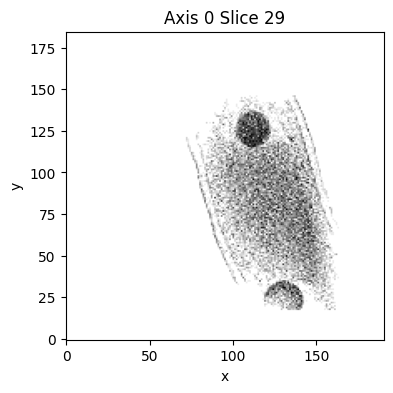

Frame: 145
Positive: [(610, 405), (625, 240), (700, 535)]
Negative: [(235, 495), (350, 265), (240, 350), (220, 690), (265, 210), (330, 705)]


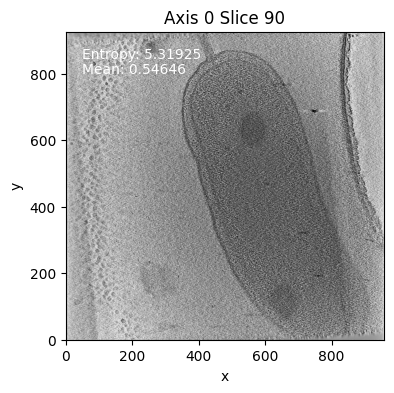

Video saved successfully at /home/matiasgp/Desktop/Toma-Analysis/presentation_videos/SAM/test1/testvideo2.mp4
JPEG frames saved in /home/matiasgp/Desktop/Toma-Analysis/presentation_videos/SAM/test1/frames


In [38]:

for path in results:
    # Extract the base name (file name with extension)
    base_name = os.path.basename(path)
    # Remove the .rec extension
    base_name = os.path.splitext(base_name)[0]
    s_path = save_path + base_name
    print(path)
    
    o_tomo = results[path]["o_tomo"]
    
    # 1. Downsample tomogram, get the highest ranked dark connecting group.
    
    tomo = downsample_3d_average(o_tomo, factor)
    
    binary_mask, mask, s_axis = select_ranked_dark_group(tomo, percentile=10)
    
    
    
    #plot_in_notebook(binary_mask, show_in_notebook=True, num_slices=10)

    # 2. Get highest entropy slice from the mask, trim the tomogram to look at the 40% part of the tomogram on each direction of the center slice.
    entropy_slice =  max_entropy_slice(mask)

    # 4. Get positive and negative points, plot
    
    positive_points, negative_points = find_points(mask, slice_number=entropy_slice, num_negative_points=6, num_positive_points=2, min_distance_percent=0.1)
    plot_specific_slice_centroid(mask, slice_number=entropy_slice) #, positive_points=positive_points, negative_points=negative_points)

    # 5.Use points for SAM --> re-scale point to use in the original tomogram
    
    scaled_entropy_slice = factor*entropy_slice
    
    rescaled_positive = upscale_points(factor, positive_points)
    
    rescaled_negative = upscale_points(factor, negative_points)
    
    print("Frame:", scaled_entropy_slice)
    print("Positive:", rescaled_positive)
    print("Negative:", rescaled_negative)
    
    plot_specific_slice_centroid(o_tomo, slice_number=90) #, positive_points=rescaled_positive, negative_points=rescaled_negative)
    
    generate_video(o_tomo, save_path="/home/matiasgp/Desktop/Toma-Analysis/presentation_videos/SAM/test1", video_name="testvideo2.mp4", speed_factor=1)


In [39]:
import numpy as np
from scipy.ndimage import label

def select_largest_dark_group(array_3d, percentile=5, connectivity=2):
    """
    Normalizes the 3D array, selects the largest dark group without cropping.
    Finds the darkest group in the entire volume. Returns a mask of the largest dark group,
    modifies the array to keep only the values in the largest group while setting all other values to 1.
    
    Parameters:
        array_3d (np.ndarray): The input 3D array.
        percentile (float): The percentile below which values are considered dark, after normalization.
        connectivity (int): The connectivity criterion (1 for direct neighbors, 2 for diagonal neighbors).
    
    Returns:
        largest_group_mask (np.ndarray): A binary mask where the largest dark group is marked as 1.
        modified_array (np.ndarray): The array with values outside the selected group set to 1, and values in the group retained.
        largest_group_size (int): The size of the largest dark group.
        normalized_array (np.ndarray): The normalized array with values in the range [0, 1].
    """
    # Normalize the array to the range [0, 1]
    array_min = np.min(array_3d)
    array_max = np.max(array_3d)
    
    # Prevent division by zero in case all values are the same
    if array_max - array_min != 0:
        normalized_array = (array_3d - array_min) / (array_max - array_min)
    else:
        normalized_array = np.zeros_like(array_3d)

    # Find values below the given percentile
    dark_values_mask = normalized_array < np.percentile(normalized_array, percentile)

    # Label connected components in the entire 3D volume
    structure = np.ones((3, 3, 3)) if connectivity == 2 else None
    labeled_array, num_features = label(dark_values_mask, structure=structure)

    if num_features == 0:
        print("No dark-value groups found.")
        return np.zeros_like(array_3d), 1, 0, normalized_array  # Return an empty mask, size 0, and a modified array of ones if no groups are found

    # Find all group sizes by counting occurrences of each label
    label_counts = np.bincount(labeled_array.flat)

    # Exclude the background label (index 0) and sort groups by size in descending order
    sorted_labels_and_sizes = sorted(enumerate(label_counts[1:], start=1), key=lambda x: x[1], reverse=True)

    # Get the label for the largest group
    largest_group_label, largest_group_size = sorted_labels_and_sizes[0]

    # Create a mask for the largest group
    largest_group_mask = labeled_array == largest_group_label

    # Modify the array: Keep only the values within the largest group, set all others to 1
    modified_array = np.where(largest_group_mask, array_3d, 1)

    return largest_group_mask, modified_array, largest_group_size, normalized_array


In [40]:
import numpy as np
from scipy.ndimage import zoom

def upscale_mask(binary_mask, original_shape, factor):
    """
    Upscale the binary mask to match the original tomogram size.
    
    Parameters:
    - binary_mask (np.ndarray): The downsampled binary mask.
    - original_shape (tuple): The shape of the original tomogram (before downsampling).
    - factor (int): The downsampling factor used earlier.
    
    Returns:
    - upscaled_mask (np.ndarray): The upscaled mask with the same shape as the original tomogram.
    """
    # Calculate the zoom factor based on the downsampling factor
    zoom_factors = [original_shape[i] / binary_mask.shape[i] for i in range(3)]
    
    # Use scipy's zoom to upscale the mask back to the original shape
    upscaled_mask = zoom(binary_mask, zoom_factors, order=0)  # Use nearest-neighbor interpolation (order=0) to retain binary values

    return upscaled_mask

def apply_mask_to_tomogram(upscaled_mask, original_tomogram):
    """
    Apply the upscaled mask to the original tomogram and keep only the values within the mask.
    
    Parameters:
    - upscaled_mask (np.ndarray): The upscaled binary mask (same shape as the original tomogram).
    - original_tomogram (np.ndarray): The original tomogram (before downsampling).
    
    Returns:
    - segmented_tomogram (np.ndarray): A new array where only the values inside the mask are retained.
    """
    # Create a new array where values outside the mask are set to zero
    segmented_tomogram = np.where(upscaled_mask, original_tomogram, 1)
    
    return segmented_tomogram

In [41]:
o_tomo = results[path]["o_tomo"]
factor = 2
    
# 1. Downsample tomogram, get the highest ranked dark connecting group.
    
tomo = downsample_3d_average(o_tomo, factor)
    
largest_group_mask, modified_array, largest_group_size, normalized_array = select_largest_dark_group(tomo, percentile=10, connectivity=1)

# # Step 1: Upscale the mask to match the original tomogram size
upscaled_mask = upscale_mask(largest_group_mask, o_tomo.shape, factor)

# # Step 2: Apply the upscaled mask to the original tomogram
segmented_tomogram = apply_mask_to_tomogram(upscaled_mask, o_tomo)

# Now, segmented_tomogram contains only the values from the original tomogram that are part of the bacterial region.
plot_in_notebook(segmented_tomogram, num_slices=30, show_in_notebook=True)

Output()

In [44]:
import os
import SimpleITK as sitk
import numpy as np

def find_first_mha_file(directory):
    """
    Search for the first .mha file in a given directory.
    
    Parameters:
    - directory: Path to the directory to search.
    
    Returns:
    - Path to the first .mha file found, or None if no file is found.
    """
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.mha'):
                return os.path.join(root, file)
    return None

def load_mha_as_numpy(mha_path):
    """
    Load a .mha file and convert it to a NumPy array.
    
    Parameters:
    - mha_path: Path to the .mha file.
    
    Returns:
    - A NumPy array containing the image data from the .mha file.
    """
    # Read the mha file using SimpleITK
    image = sitk.ReadImage(mha_path)
    
    # Convert the image to a NumPy array
    numpy_array = sitk.GetArrayFromImage(image)
    
    return numpy_array

# Set the directory to search
directory = "/home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/Segmentation/SegData/dataset_10084"

# Find the first .mha file in the directory
mha_file = find_first_mha_file(directory)

if mha_file:
    print(f"Found .mha file: {mha_file}")
    
    # Load the .mha file and convert it to a NumPy array
    image_array = load_mha_as_numpy(mha_file)
    
    print(f"Loaded .mha file as NumPy array with shape: {image_array.shape}")
else:
    print("No .mha file found in the directory.")

plot_in_notebook(image_array, show_in_notebook=True)

Found .mha file: /home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/Segmentation/SegData/dataset_10084/seg_6073.mha
Loaded .mha file as NumPy array with shape: (300, 960, 928)


Output()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_closing
import cv2

# Assuming image_array is your 3D array (e.g., shape: [num_slices, height, width])
closed_masks = np.zeros_like(image_array)  # Initialize an array to store closed masks

for i in range(image_array.shape[0]):
    slice_2d = image_array[i, :, :]  # Extract slice
    closed_masks[i, :, :] = binary_closing(slice_2d, structure=np.ones((5, 5)))  # Apply binary closing

# Call the plot_in_notebook function (Assuming save_path is the directory path where you want to save)
plot_in_notebook(closed_masks, show_in_notebook=True)  # Use the correct save path as a string


Implement SAM 2